# Getting started

This notebook shows how to get started with Quantus on tensorflow, using a very simple example.

In [1]:
# Imports general.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.image import grayscale_to_rgb
import tf_explain

import quantus
from quantus.metrics import *

## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [9]:
# Load datasets
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2022-03-16 20:19:22.272810: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


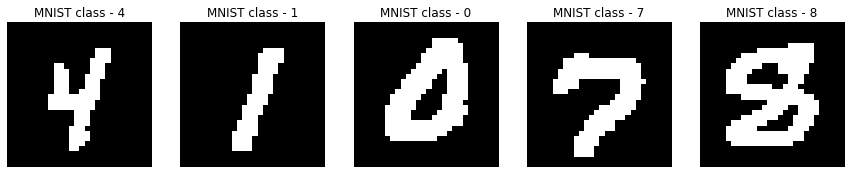

In [10]:
# Plot some inputs!
i = 0
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for x_batch, y_batch in ds_train.take(nr_images):
    axes[i].imshow((np.reshape(x_batch.numpy(), (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"MNIST class - {y_batch}")
    axes[i].axis("off")
    i += 1

plt.show()

In [11]:
# Build a training pipeline

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.expand_dims(tf.cast(image, tf.float32), axis = 3) / 255., label

def to_rgb(image, label):
    return grayscale_to_rgb(image), label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [12]:
# Build an evaluation pipeline
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [13]:
x_batch, y_batch = next(iter(ds_test))
x_batch = x_batch.numpy() [:,:,:,0]
y_batch = y_batch.numpy() 

2022-03-16 20:19:24.112291: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-03-16 20:19:24.112320: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### 1.2 Train a model

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

print(f"\n Model architecture: {model.summary()}\n")

Epoch 1/6
469/469 [==============================] - 1s 1ms/step - loss: 0.3657 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.1961 - val_sparse_categorical_accuracy: 0.9434
Epoch 2/6
469/469 [==============================] - 0s 943us/step - loss: 0.1643 - sparse_categorical_accuracy: 0.9526 - val_loss: 0.1385 - val_sparse_categorical_accuracy: 0.9590
Epoch 3/6
469/469 [==============================] - 0s 945us/step - loss: 0.1180 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.1101 - val_sparse_categorical_accuracy: 0.9680
Epoch 4/6
469/469 [==============================] - 0s 942us/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.0975 - val_sparse_categorical_accuracy: 0.9707
Epoch 5/6
469/469 [==============================] - 0s 950us/step - loss: 0.0734 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0920 - val_sparse_categorical_accuracy: 0.9722
Epoch 6/6
469/469 [==============================] - 0s 945us/step - loss: 0.0608 - sparse_catego

### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [16]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch_intgrad = (
            np.array(
                list(
                    map(
                        lambda x, y: tf_explain.core.integrated_gradients.IntegratedGradients().explain(
                            ([x], None), model, y, n_steps=10
                        ),
                        x_batch,
                        y_batch,
                    )
                ),
                dtype=float,
            )
            / 255
        )

Visualise attributions given model and pairs of input-output.

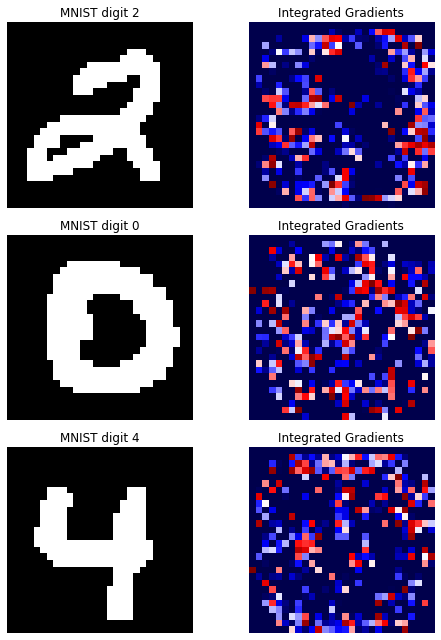

In [17]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*2.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow((np.reshape(x_batch[i], (28, 28)) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"MNIST digit {y_batch[i].item()}")
    axes[i, 0].axis("off")
    a = axes[i, 1].imshow(a_batch_intgrad[i], cmap="seismic")
    axes[i, 1].title.set_text(f"Integrated Gradients")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

## 2. Quantative evaluation using Quantus

We can evaluate our explanations on a variety of quantuative criteria but as a motivating example we test the Max-Sensitivity (Yeh at el., 2019) of the explanations. This metric tests how the explanations maximally change while subject to slight perturbations.

In [28]:
# Define params for evaluation.
params_eval_maxs = {
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_noise,
    "similarity_func": quantus.difference,
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
}

In [29]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
scores_intgrad_maxs = quantus.MaxSensitivity(**params_eval_maxs)(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_intgrad,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "img_size": 28, "normalise": True, "abs": True})

In [38]:
metrics = {"max-Sensitivity": quantus.MaxSensitivity(**params_eval_maxs)}

xai_methods = {"IntegratedGradients": a_batch_intgrad}

results = quantus.evaluate(evaluation_metrics=metrics,
                           explanation_methods=xai_methods,
                           model=model,
                           x_batch=x_batch,
                           y_batch=y_batch,
                           agg_func=np.mean,
                           metrics = metrics,
                           xai_methods = xai_methods,
                           **{"explain_func": quantus.explain, "img_size": 28, "normalise": False, "abs": False})

df = pd.DataFrame(results)
df

,IntegratedGradients
max-Sensitivity,0.659003


In [39]:
# Calculate Selectivity (Ancona et al., 2019)
params_eval_slct = {
    "perturb_func": quantus.baseline_replacement_by_patch,
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "perturb_baseline": "random",
    "patch_size": 4,
    "nr_channels": 1
}

scores_intgrad_slct = quantus.Selectivity(**params_eval_slct)(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_intgrad,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "img_size": 28, "normalise": True, "abs": True})

### Relative input stability [arxiv](https://arxiv.org/pdf/2203.06877.pdf)
    we randomly increase bightness of some pixels to create sligtly shifted batch of data points aka xs

In [ ]:
aug_layer = tf.keras.layers.RandomBrightness(factor=0.01, training=True)

xs_batch = aug_layer(x_batch)
ys_batch = model(xs_batch)

relative_input_stability_score = quantus.RelativeInputStability(
    x_batch=x_batch,
    xs_batch=xs_batch,
    ys_batch=ys_batch,
    y_batch=y_batch,
    explain_func=quantus.explain
)

print(f'{relative_input_stability_score = }')